# Stock Market Prediction Using Numerical & Textual Analysis

## Importing Libraries

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost 
import lightgbm 


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load the Textual Data

In [3]:
df_text = pd.read_csv("../input/india-headlines-news-dataset/india-news-headlines.csv")
df_text.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


## Handling with Textual Data:

In [4]:
df_text.drop(0, inplace=True)
df_text.drop('headline_category', axis = 1, inplace=True)
df_text.head()



,publish_date,headline_text
1,20010102,Fissures in Hurriyat over Pak visit
2,20010102,America's unwanted heading for India?
3,20010102,For bigwigs; it is destination Goa
4,20010102,Extra buses to clear tourist traffic
5,20010102,Dilute the power of transfers; says Riberio


In [5]:
df_text["publish_date"] = pd.to_datetime(df_text["publish_date"],format='%Y%m%d')
df_text.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424066 entries, 1 to 3424066
Data columns (total 2 columns):
 #   Column         Dtype         
---  ------         -----         
 0   publish_date   datetime64[ns]
 1   headline_text  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 78.4+ MB


In [6]:
df_text.shape

(3424066, 2)

In [7]:
df_text.isnull().sum()


publish_date     0
headline_text    0
dtype: int64

In [8]:
df_text['headline_text'] = df_text.groupby(['publish_date']).transform(lambda x : ' '.join(x)) 
df_text = df_text.drop_duplicates() 
len(df_text)

7262

In [9]:
df_text

,publish_date,headline_text
1,2001-01-02,Fissures in Hurriyat over Pak visit America's ...
86,2001-01-03,Powerless north India gropes in the dark Think...
127,2001-01-04,The string that pulled Stephen Hawking to Indi...
280,2001-01-05,Light combat craft takes India into club class...
406,2001-01-06,Light combat craft takes India into club class...
...,...,...
3421573,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
3422072,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
3422570,2020-12-29,Man recovers charred remains of 'thief' from h...
3423069,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [10]:
df_text.reset_index(inplace=True,drop=True)


#### Remove Unwanted Characters from the head_line text


In [11]:
df_text.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
df_text["headline_text"].head(5)


0    Fissures in Hurriyat over Pak visit America's ...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: headline_text, dtype: object

In [12]:
def Subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def Polarity(text):
  return  TextBlob(text).sentiment.polarity

df_text['Subjectivity'] = df_text['headline_text'].apply(Subjectivity)
df_text['Polarity'] = df_text['headline_text'].apply(Polarity)
df_text



,publish_date,headline_text,Subjectivity,Polarity
0,2001-01-02,Fissures in Hurriyat over Pak visit America's ...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930


### Visualize a Polarity and Subjectivity


<AxesSubplot:>

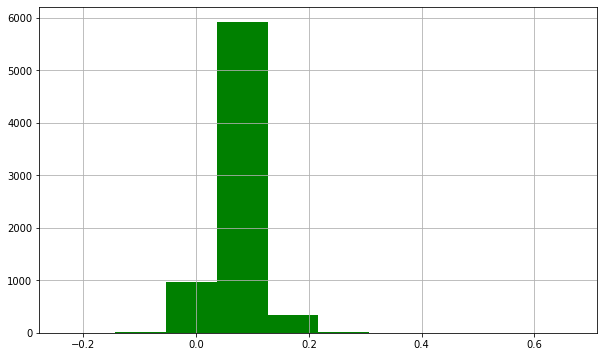

In [13]:
plt.figure(figsize = (10,6))
df_text['Polarity'].hist(color = 'green')


<AxesSubplot:>

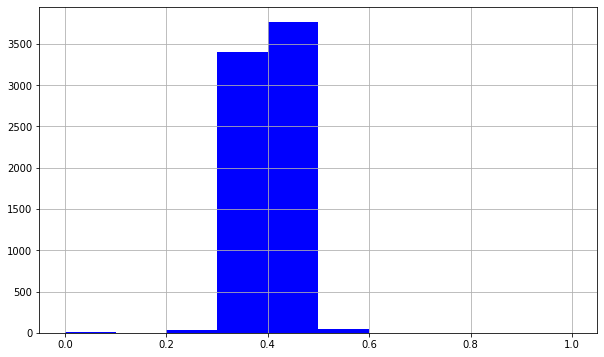

In [14]:
plt.figure(figsize = (10,6))
df_text['Subjectivity'].hist(color = 'blue')


### Sentiment Analysis using News Headlines




In [15]:
snt = SentimentIntensityAnalyzer()



In [16]:
df_text['Compound'] = [snt.polarity_scores(v)['compound'] for v in df_text['headline_text']]
df_text['Negative'] = [snt.polarity_scores(v)['neg'] for v in df_text['headline_text']]
df_text['Neutral'] = [snt.polarity_scores(v)['neu'] for v in df_text['headline_text']]
df_text['Positive'] = [snt.polarity_scores(v)['pos'] for v in df_text['headline_text']]
df_text


,publish_date,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Fissures in Hurriyat over Pak visit America's ...,0.286859,0.143590,-0.9804,0.123,0.808,0.069
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9365,0.142,0.696,0.161
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978,-0.9997,0.129,0.793,0.079
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.142,0.761,0.097
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.151,0.753,0.096
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.146,0.770,0.084


## Load the Numerical Data 

In [17]:
df_num = pd.read_csv("../input/numerical-stock-prices/QMCI.csv")
df_num.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-08,0.20,0.22,0.19,0.19,0.19,70200
1,2021-02-09,0.19,0.21,0.19,0.19,0.19,51600
2,2021-02-10,0.39,0.40,0.24,0.27,0.27,4710100
3,2021-02-11,0.28,0.32,0.27,0.28,0.28,795700
4,2021-02-12,0.27,0.28,0.21,0.22,0.22,595600


## Handling with Numerical Data

All the things that are going to happen in this data must be related to time to this index.

In [18]:
df_num["Date"] = pd.to_datetime(df_num["Date"],format='%Y-%m-%d')
df_num.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Open       252 non-null    float64       
 2   High       252 non-null    float64       
 3   Low        252 non-null    float64       
 4   Close      252 non-null    float64       
 5   Adj Close  252 non-null    float64       
 6   Volume     252 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 13.9 KB


Let's see how the data will be like:

In [19]:
df_num

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-08,0.20,0.22,0.19,0.19,0.19,70200
1,2021-02-09,0.19,0.21,0.19,0.19,0.19,51600
2,2021-02-10,0.39,0.40,0.24,0.27,0.27,4710100
3,2021-02-11,0.28,0.32,0.27,0.28,0.28,795700
4,2021-02-12,0.27,0.28,0.21,0.22,0.22,595600
...,...,...,...,...,...,...,...
247,2022-01-31,0.16,0.16,0.16,0.16,0.16,0
248,2022-02-01,0.16,0.16,0.16,0.16,0.16,600
249,2022-02-02,0.17,0.17,0.17,0.17,0.17,1000
250,2022-02-03,0.16,0.16,0.16,0.16,0.16,100


In [20]:
df_num.describe()


,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,0.186706,0.192540,0.181111,0.185675,0.185675,7.413571e+04
std,0.022277,0.025419,0.015369,0.018336,0.018336,3.063803e+05
min,0.160000,0.160000,0.150000,0.150000,0.150000,0.000000e+00
25%,0.170000,0.180000,0.170000,0.170000,0.170000,7.775000e+03
50%,0.180000,0.190000,0.180000,0.180000,0.180000,2.820000e+04
75%,0.190000,0.200000,0.190000,0.190000,0.190000,6.582500e+04
max,0.390000,0.400000,0.270000,0.280000,0.280000,4.710100e+06


In [21]:
#check for null values
df_num.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0, 0.5, 'QMCI')

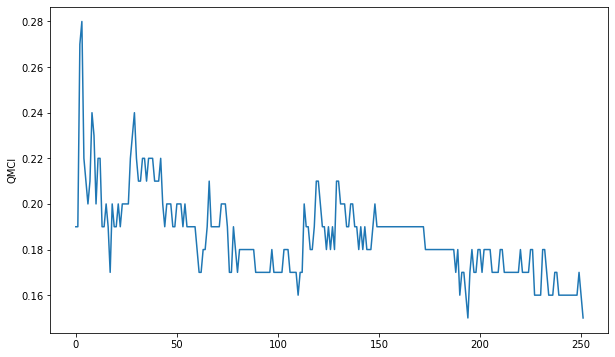

In [22]:
plt.figure(figsize=(10,6))
df_num['Close'].plot()
plt.ylabel('QMCI')


### Plotting Moving Average

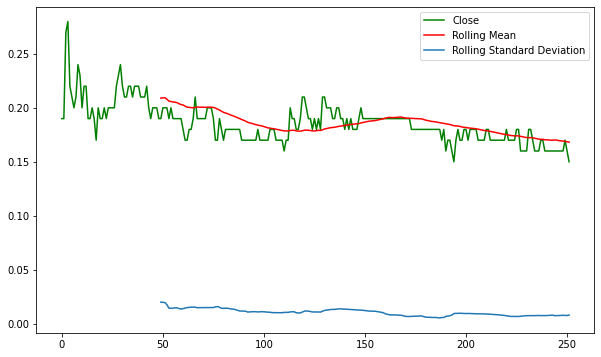

In [23]:
close = df_num['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10,6))
df_num['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()



In [24]:
#split the data to train and test
train = df_num[:200]
test = df_num[200:]


### Rolling mean and Standard Deviation


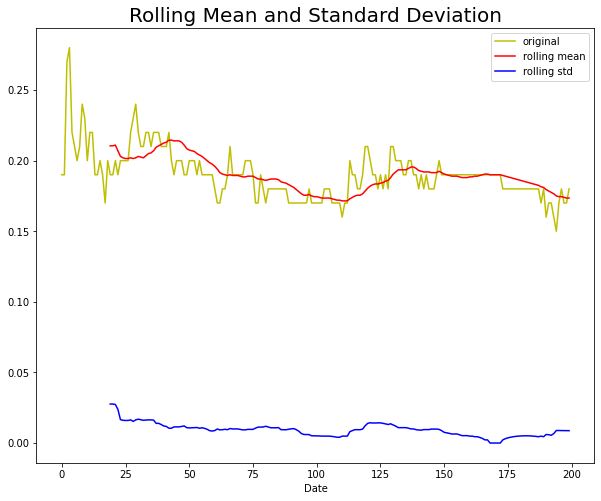

Results of dickey fuller test
ADF Test Statistic : -2.6310567849620403
p-value : 0.08674682352531471
#Lags Used : 5
Number of Observations Used : 194
Weak evidence against null hypothesis, time series is non-stationary 


In [25]:
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])


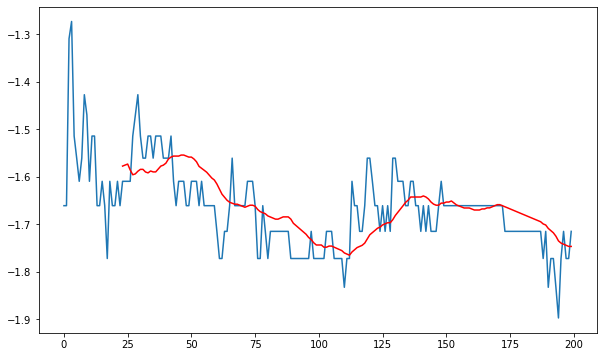

In [26]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 


## Auto arima to make predictions using log data


In [27]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 516 kB/s            


In [28]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-600.405, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-569.632, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-570.766, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-576.677, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-571.627, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-600.989, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-602.012, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-601.557, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-595.176, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-603.062, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-608.680, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-598.439, Time=0.59 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-610.889, Time=1.43 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-604.037, Time=1.02 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept

#### Visualize Prediction

Text(0, 0.5, 'Actual Stock Price')

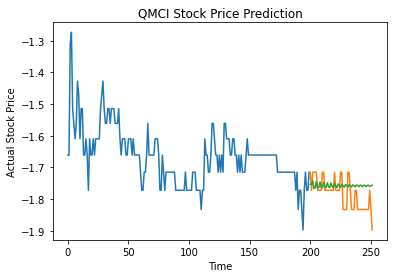

In [29]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('QMCI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')


In [30]:
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)


RMSE :  0.05305130554969066


## Merging the Numerical and Textual Data


In [31]:
merge = df_text
merge

,publish_date,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Fissures in Hurriyat over Pak visit America's ...,0.286859,0.143590,-0.9804,0.123,0.808,0.069
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9365,0.142,0.696,0.161
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978,-0.9997,0.129,0.793,0.079
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.142,0.761,0.097
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.151,0.753,0.096
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.146,0.770,0.084


In [32]:
data = merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
data


,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.286859,0.143590,-0.9804,0.123,0.808,0.069
1,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,0.480553,0.264024,0.9365,0.142,0.696,0.161
4,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...
7257,0.392082,0.042978,-0.9997,0.129,0.793,0.079
7258,0.409973,0.071405,-0.9998,0.142,0.761,0.097
7259,0.415684,0.060775,-0.9999,0.151,0.753,0.096
7260,0.436863,0.046930,-0.9999,0.146,0.770,0.084


In [33]:
X = data[:252]
y = df_num['Close']


In [34]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape


(201, 6)

## Apply Models

### RandomForestRegressor Model

In [35]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)


In [37]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))


[0.1808 0.2    0.1746 0.188  0.1747 0.1738 0.1846 0.1764 0.192  0.178 ]
158    0.19
83     0.18
170    0.19
101    0.17
150    0.19
199    0.18
118    0.19
227    0.16
63     0.18
135    0.19
Name: Close, dtype: float64
Mean Squared error:  0.00024587451153646784


### DecisionTreeRegressor Model

In [38]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)
print('Mean Squared error: ',mean_squared_error(predictions,y_test))


Mean Squared error:  0.0005138480392156864


### XGBRegressor Model

In [39]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)
predictions = xgb.predict(x_test)
print('Mean Squared error: ',mean_squared_error(predictions,y_test))


Mean Squared error:  0.0002865711676554356


## Conclusion:
we can see that RandomForestRegressor shows a better performance than the others